In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import pandas as pd
import seaborn as sns

sns.set(style="whitegrid")

# import the data and the sam data for cleaning, change directory if needed
# the 1st must be the code violations, 2nd the sam addresses, and 3rd the building violstions
df1 = pd.read_csv("./code_enforcement_violations.csv")
df2 = pd.read_csv("./Live_Street_Address_Management_(SAM)_Addresses.csv")
df3 = pd.read_csv("./build_prop_violations.csv")

C:\Users\Wang\AppData\Local\Temp\ipykernel_20796\190783226.py:12: DtypeWarning: Columns (8,9,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("./Live_Street_Address_Management_(SAM)_Addresses.csv")


In [2]:
#Process takes in 3 databases and processes them
def Process(code_vio, prop_vio, sam_addr):
    # rename the columns in the sam dataset to prepare for merging
    sam_addr.rename(columns={'SAM_ADDRESS_ID': 'sam_id', 'FULL_ADDRESS': 'full_address'}, inplace=True)
    # select only the wanted columns
    sam_addr = sam_addr[['full_address', 'sam_id', 'PARCEL']]
    # fix sam_id in df3 to get rid of the decimal, just in case
    # we drop missing sam_id for all data
    prop_vio.dropna(subset = ['sam_id'], inplace = True)
    code_vio.dropna(subset = ['sam_id'], inplace = True)
    prop_vio['sam_id'] = prop_vio['sam_id'].astype(int)
    # merge the datasets
    merged_code_vio = pd.merge(code_vio, sam_addr, on=['sam_id'], how='left')
    merged_prop_vio = pd.merge(prop_vio, sam_addr, on=['sam_id'], how='left')
    # drop the empty addresses, caused by missing sam addresses from what I can tell
    merged_code_vio.dropna(subset = ['full_address'], inplace = True)
    merged_prop_vio.dropna(subset = ['full_address'], inplace = True)
    # final clean by dropping apartment numbers ex. 13 Commonwealth #1 -> 13 Commonwealth
    merged_code_vio['full_address'] = merged_code_vio['full_address'].str.split(' #')
    merged_prop_vio['full_address'] = merged_prop_vio['full_address'].str.split(' #')
    # more misc cleaning and final check that all addresses are good if needed
    merged_code_vio.dropna(subset = ['ticket_no'], inplace = True)
    # print(merged_prop_vio.isnull().sum()) uncomment if needed for checking
    # print(merged_code_vio.isnull().sum())
    return merged_code_vio, merged_prop_vio

In [3]:
processed_code_vio, processed_build_vio = Process(df1, df3, df2)


### We have two merged datasets `processed_code_vio, processed_build_vio`

## Building violators

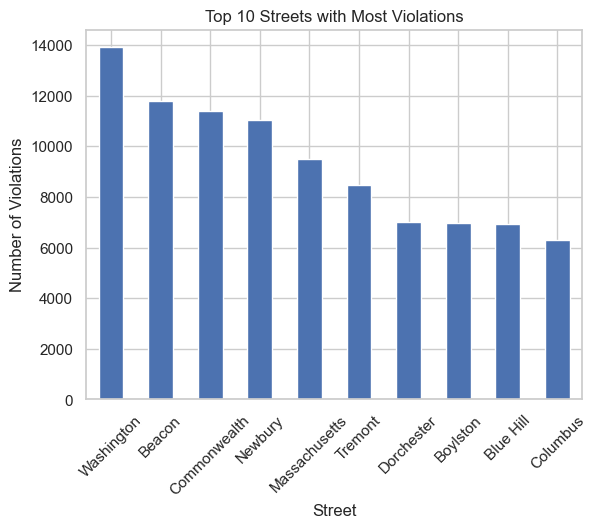

In [22]:
street_violation_counts = processed_code_vio['violation_street'].value_counts()

# 选择违规次数最多的前10个街道
top_streets = street_violation_counts.head(10)

# 绘制柱状图
top_streets.plot(kind='bar')
plt.title('Top 10 Streets with Most Violations')
plt.xlabel('Street')
plt.ylabel('Number of Violations')
plt.xticks(rotation=45)
plt.show()

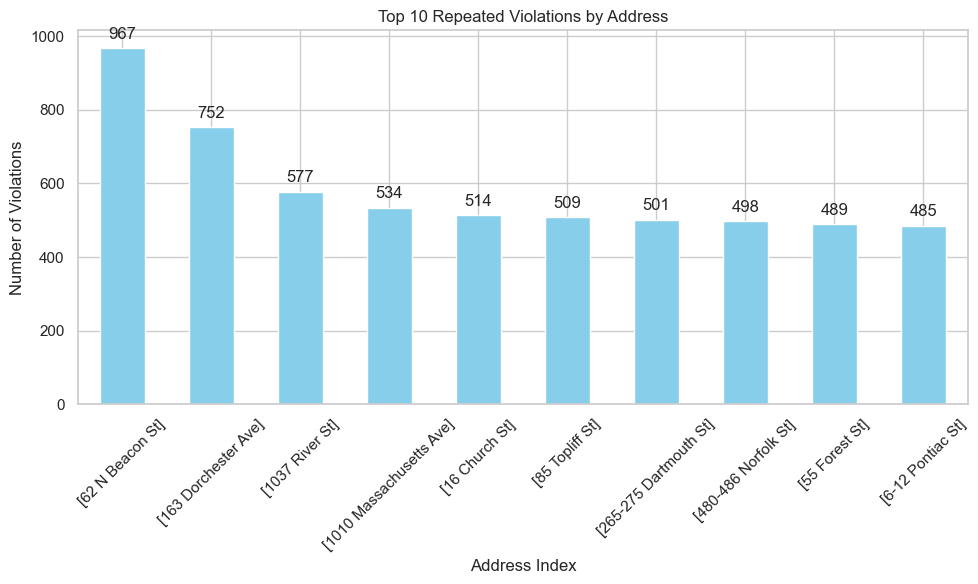

In [17]:
## This will take a long time to generate the figure
violation_counts = processed_code_vio['full_address'].value_counts()

repeated_violations = violation_counts[violation_counts > 2]
repeated_violations.head(20)
# 选择排名前10的违规次数
top_10_repeated_violations = repeated_violations.head(10)

# 绘制柱状图
fig, ax = plt.subplots(figsize=(10, 6))
top_10_repeated_violations.plot(kind='bar', ax=ax, color='skyblue')
ax.set_title('Top 10 Repeated Violations by Address')
ax.set_xlabel('Address Index')
ax.set_ylabel('Number of Violations')

# 在每个柱子上标注数值
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


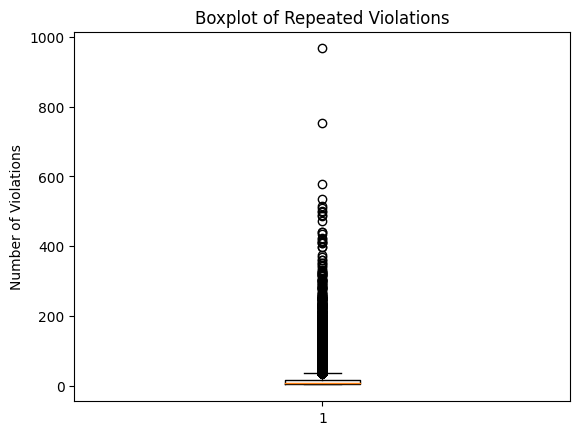

In [27]:
plt.style.use('default')
plt.boxplot(repeated_violations.values)
plt.title('Boxplot of Repeated Violations')
plt.ylabel('Number of Violations')
plt.show()

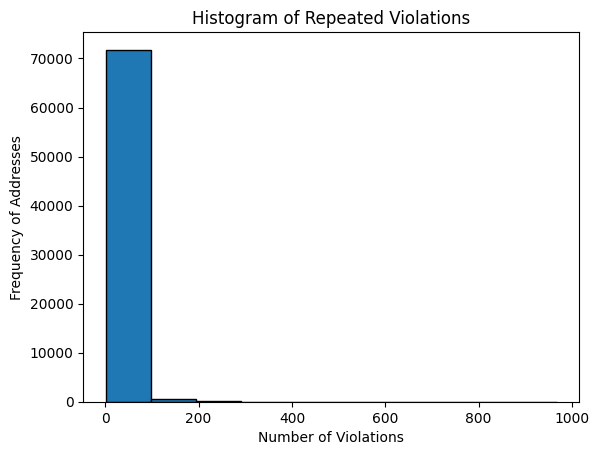

In [29]:
plt.hist(violation_counts, bins=10, edgecolor='black')
plt.title('Histogram of Repeated Violations')
plt.xlabel('Number of Violations')
plt.ylabel('Frequency of Addresses')
plt.show()

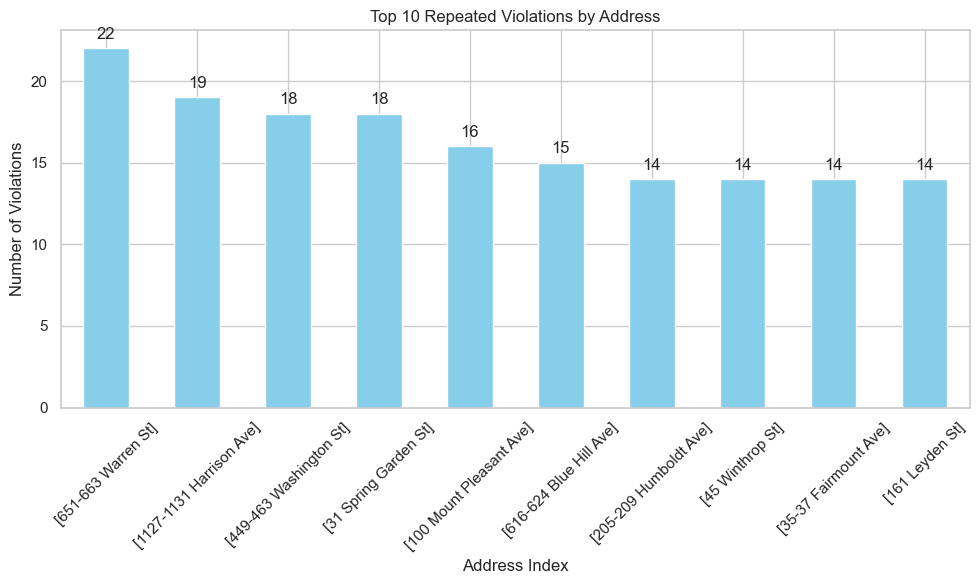

In [25]:
violation_counts2 = processed_build_vio['full_address'].value_counts()

repeated_violations2 = violation_counts2[violation_counts2 > 2]
repeated_violations2.head(20)
# 选择排名前10的违规次数
top_10_repeated_violations2 = repeated_violations2.head(10)

# 绘制柱状图
fig, ax = plt.subplots(figsize=(10, 6))
top_10_repeated_violations2.plot(kind='bar', ax=ax, color='skyblue')
ax.set_title('Top 10 Repeated Violations by Address')
ax.set_xlabel('Address Index')
ax.set_ylabel('Number of Violations')

# 在每个柱子上标注数值
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


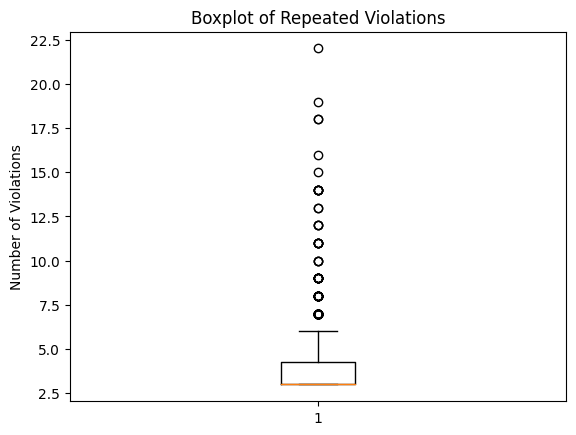

In [28]:
plt.boxplot(repeated_violations2.values)
plt.title('Boxplot of Repeated Violations')
plt.ylabel('Number of Violations')
plt.show()

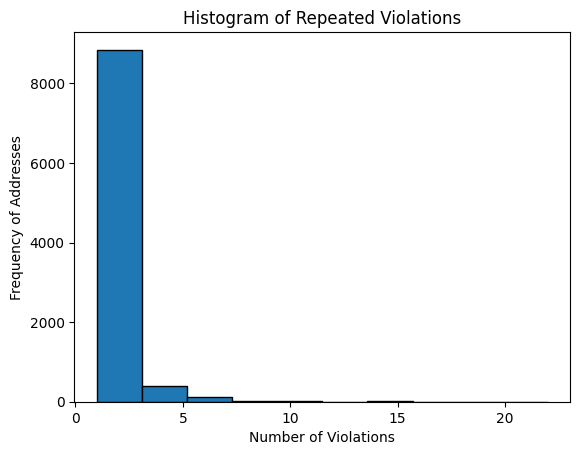

In [30]:
plt.hist(violation_counts2, bins=10, edgecolor='black')
plt.title('Histogram of Repeated Violations')
plt.xlabel('Number of Violations')
plt.ylabel('Frequency of Addresses')
plt.show()

In [8]:
processed_build_vio['full_address'].head()

0              [83 Tyler St]
1            [302 Sumner St]
2       [123 Nottinghill Rd]
3    [272-276 Hyde Park Ave]
4         [44 Longfellow St]
Name: full_address, dtype: object

## New part(Building Features)

### Load the property assessment data

In [1]:
import pandas as pd
property_df = pd.read_csv('fy2023-property-assessment-data.csv')

### Merged it with the `processed_code_vio, processed_build_vio` dataset.(`property_processed_build_vio, property_processed_code_vio`)

In [2]:
property_df['Extracted_Address'] = property_df['OWNER MAIL ADDRESS'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else x)
# Remove the "#" character from the extracted addresses
property_df['Extracted_Address_Cleaned'] = property_df['Extracted_Address'].str.replace("#", "").str.upper()

# Showing the first few rows of the dataframe to confirm the removal
property_df[['OWNER MAIL ADDRESS', 'Extracted_Address', 'Extracted_Address_Cleaned']].head()


,OWNER MAIL ADDRESS,Extracted_Address,Extracted_Address_Cleaned
0,"195 LEXINGTON ST, EAST BOSTON, MA 02128",195 LEXINGTON ST,195 LEXINGTON ST
1,"197 LEXINGTON ST, EAST BOSTON, MA 02128",197 LEXINGTON ST,197 LEXINGTON ST
2,"199 LEXINGTON ST, EAST BOSTON, MA 02128",199 LEXINGTON ST,199 LEXINGTON ST
3,"PO BOX 557 #, EVERETT, MA 02149",PO BOX 557 #,PO BOX 557
4,"203 Lexington ST, EAST BOSTON, MA 02128",203 Lexington ST,203 LEXINGTON ST


In [6]:
property_processed_build_vio = property_df[property_df['PID'].isin(processed_build_vio['PARCEL'])]

property_processed_build_vio.shape

(4345, 62)

In [7]:
property_processed_code_vio = property_df[property_df['PID'].isin(processed_code_vio['PARCEL'])]

property_processed_code_vio.shape

(28902, 62)

### Analyse the `property_processed_build_vio`

In [8]:
property_processed_build_vio.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,UNIT_NUM,CITY,ZIP_CODE,BLDG_SEQ,NUM_BLDGS,...,HEAT_TYPE,HEAT_FUEL,AC_TYPE,FIREPLACES,ORIENTATION,NUM_PARKING,PROP_VIEW,CORNER_UNIT,Extracted_Address,Extracted_Address_Cleaned
0,100001000,NaN,100001000,104.0,PUTNAM ST,NaN,EAST BOSTON,2128.0,1.0,1,...,W - Ht Water/Steam,NaN,N - None,0.0,NaN,3.0,A - Average,NaN,195 LEXINGTON ST,195 LEXINGTON ST
5,100006000,NaN,100006000,205.0,Lexington ST,NaN,EAST BOSTON,2128.0,1.0,1,...,E - Electric,NaN,N - None,0.0,NaN,0.0,A - Average,NaN,28 LAUDHOLM RD,28 LAUDHOLM RD
6,100007000,NaN,100007000,209.0,Lexington ST,NaN,EAST BOSTON,2128.0,1.0,1,...,W - Ht Water/Steam,NaN,N - None,0.0,NaN,0.0,A - Average,NaN,-211 209 LEXINGTON ST,-211 209 LEXINGTON ST
10,100011000,NaN,100011000,219.0,Lexington ST,NaN,EAST BOSTON,2128.0,1.0,1,...,F - Forced Hot Air,NaN,C - Central AC,0.0,NaN,0.0,A - Average,NaN,219 LEXINGTON ST,219 LEXINGTON ST
12,100013000,NaN,100013000,223.0,Lexington ST,NaN,EAST BOSTON,2128.0,1.0,1,...,W - Ht Water/Steam,NaN,N - None,0.0,NaN,0.0,A - Average,NaN,103 ST ANDREW RD #2,103 ST ANDREW RD 2


In [9]:
property_processed_build_vio.to_csv('property2023_build_vio.csv', index=False)

In [5]:
prodf = pd.read_csv('property2023_build_vio.csv')

In [11]:
prodf['Extracted_Address'] = prodf['OWNER MAIL ADDRESS'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else x)
prodf['Extracted_Address_Cleaned'] = prodf['Extracted_Address'].str.replace("#", "").str.upper()

top_addresses = prodf['Extracted_Address_Cleaned'].value_counts().head(10)

top_addresses

330 ADAMS ST                                                                12
40 EVERETT ST                                                               11
1249 BEACON ST STE 1 C/O ALPHA MANAGEMENT CORP                               9
C/O CODMAN SQUARE NEIGHBORHOOD DEVELOPMENT CORPORATION 587 WASHINGTON ST     9
C/O EBCDC INC 72 MARGINAL ST                                                 7
1616  CAMDEN  ROAD  SUITE 210 C/O  ASANA  PARTNERS                           7
C/O 388 LLC PROPERTY MANAGEMENT 388 EAST 8TH ST                              7
1495 HANCOCK ST 4TH FLR                                                      6
103 CLAYTON ST                                                               5
530 WARREN ST C/O UNITED HOUSING CO LLC                                      5
Name: Extracted_Address_Cleaned, dtype: int64

In [12]:
## Overview of the top 10 
top_addresses_list = top_addresses.index.tolist()

address_info = {}

for address in top_addresses_list:
    address_rows = prodf[prodf['Extracted_Address_Cleaned'] == address]
    
    address_info[address] = {
        'BLDG_TYPE': address_rows['BLDG_TYPE'].iloc[0],
        'YR_BUILT': address_rows['YR_BUILT'].iloc[0],
        'YR_REMODEL': address_rows['YR_REMODEL'].iloc[0]
    }

for address, info in address_info.items():
    print(f"Address: {address}")
    for key, value in info.items():
        print(f"  {key}: {value}")
    print()


Address: 330 ADAMS ST
  BLDG_TYPE: 111 - APT 4-6 UNITS
  YR_BUILT: 2019.0
  YR_REMODEL: nan

Address: 40 EVERETT ST
  BLDG_TYPE: TF - Two Fam Stack
  YR_BUILT: 1920.0
  YR_REMODEL: 2015.0

Address: 1249 BEACON ST STE 1 C/O ALPHA MANAGEMENT CORP
  BLDG_TYPE: 112 - APT 7-30 UNITS
  YR_BUILT: 1899.0
  YR_REMODEL: 2015.0

Address: C/O CODMAN SQUARE NEIGHBORHOOD DEVELOPMENT CORPORATION 587 WASHINGTON ST
  BLDG_TYPE: 111 - APT 4-6 UNITS
  YR_BUILT: 1905.0
  YR_REMODEL: nan

Address: C/O EBCDC INC 72 MARGINAL ST
  BLDG_TYPE: VT - Victorian
  YR_BUILT: 1905.0
  YR_REMODEL: nan

Address: 1616  CAMDEN  ROAD  SUITE 210 C/O  ASANA  PARTNERS
  BLDG_TYPE: 320 - RET/WHSL/SERVICE
  YR_BUILT: 1899.0
  YR_REMODEL: 2020.0

Address: C/O 388 LLC PROPERTY MANAGEMENT 388 EAST 8TH ST
  BLDG_TYPE: RE - Row End
  YR_BUILT: 1890.0
  YR_REMODEL: nan

Address: 1495 HANCOCK ST 4TH FLR
  BLDG_TYPE: 112 - APT 7-30 UNITS
  YR_BUILT: 1920.0
  YR_REMODEL: 1972.0

Address: 103 CLAYTON ST
  BLDG_TYPE: SD - Semi-Det
  YR_B

### Some graph

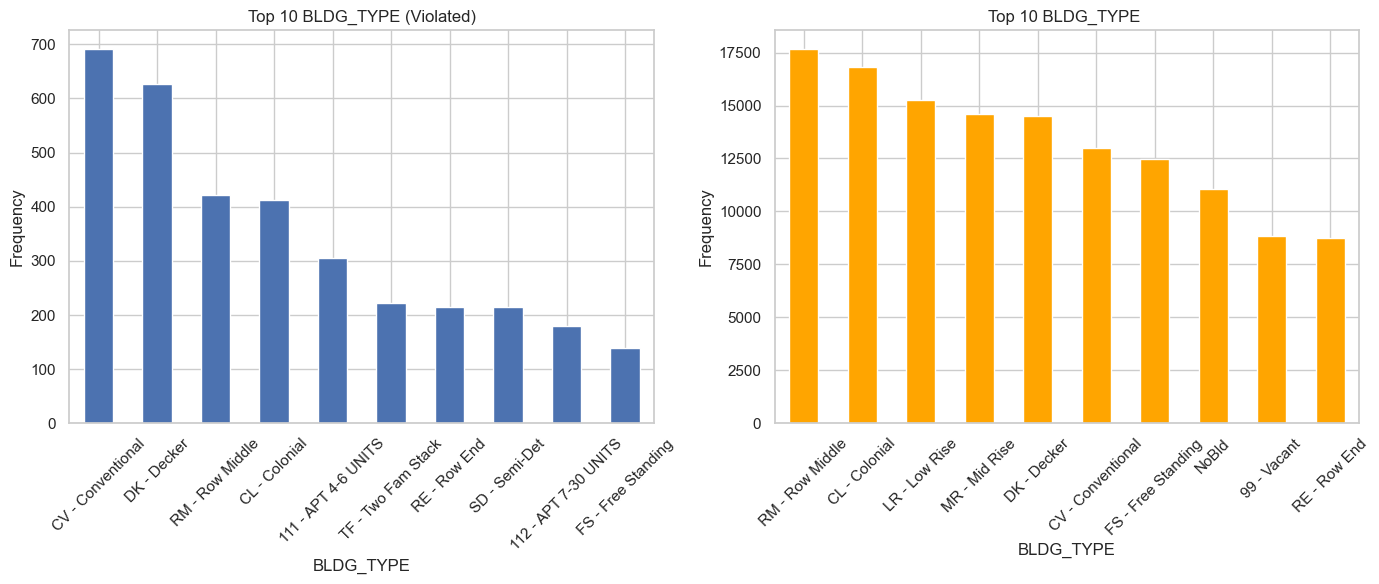

In [16]:
import matplotlib.pyplot as plt

top_build_type_prodf = prodf['BLDG_TYPE'].value_counts().head(10)
top_build_type_property_df = property_df['BLDG_TYPE'].value_counts().head(10)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
top_build_type_prodf.plot(kind='bar')
plt.title('Top 10 BLDG_TYPE (Violated)')
plt.xlabel('BLDG_TYPE')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2) 
top_build_type_property_df.plot(kind='bar', color='orange')
plt.title('Top 10 BLDG_TYPE ')
plt.xlabel('BLDG_TYPE')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


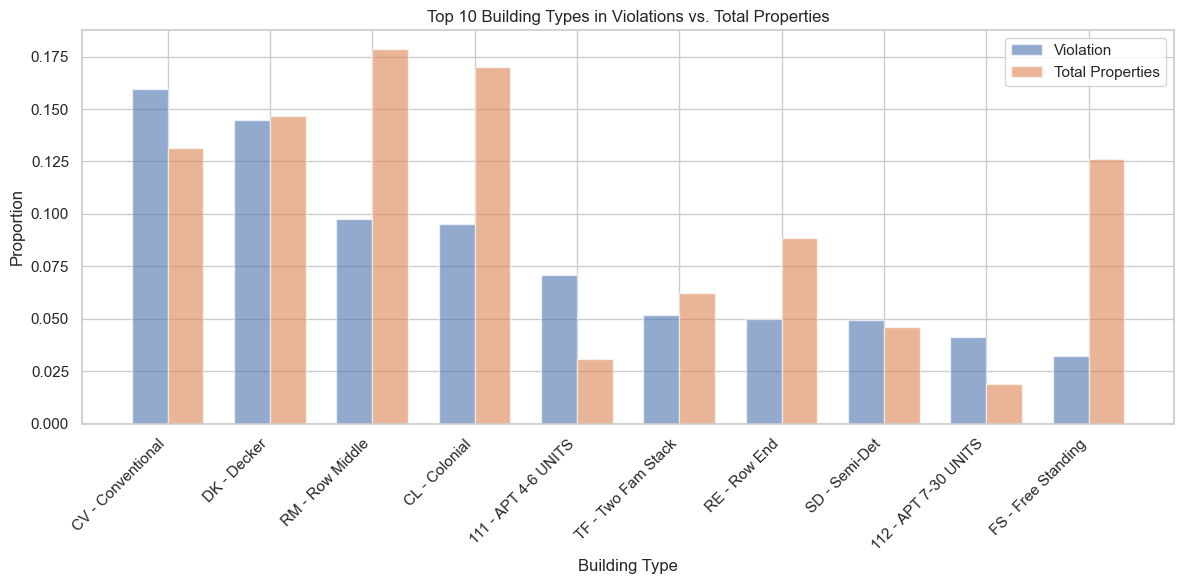

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

top_10_violation_types = prodf['BLDG_TYPE'].value_counts().head(10).index

top_10_violation_proportions = prodf['BLDG_TYPE'].value_counts(normalize=True).loc[top_10_violation_types]

top_10_property_proportions = property_df[property_df['BLDG_TYPE'].isin(top_10_violation_types)]['BLDG_TYPE'].value_counts(normalize=True)
top_10_property_proportions = top_10_property_proportions.reindex(top_10_violation_types)

plt.figure(figsize=(12, 6))

bar_width = 0.35
index = pd.Index(range(len(top_10_violation_types)))

plt.bar(index, top_10_violation_proportions, bar_width, label='Violation', alpha=0.6)

plt.bar(index + bar_width, top_10_property_proportions, bar_width, label='Total Properties', alpha=0.6)

plt.legend()

plt.title('Top 10 Building Types in Violations vs. Total Properties')
plt.xlabel('Building Type')
plt.ylabel('Proportion')
plt.xticks(index + bar_width / 2, top_10_violation_types, rotation=45, ha='right')

plt.tight_layout()
plt.show()


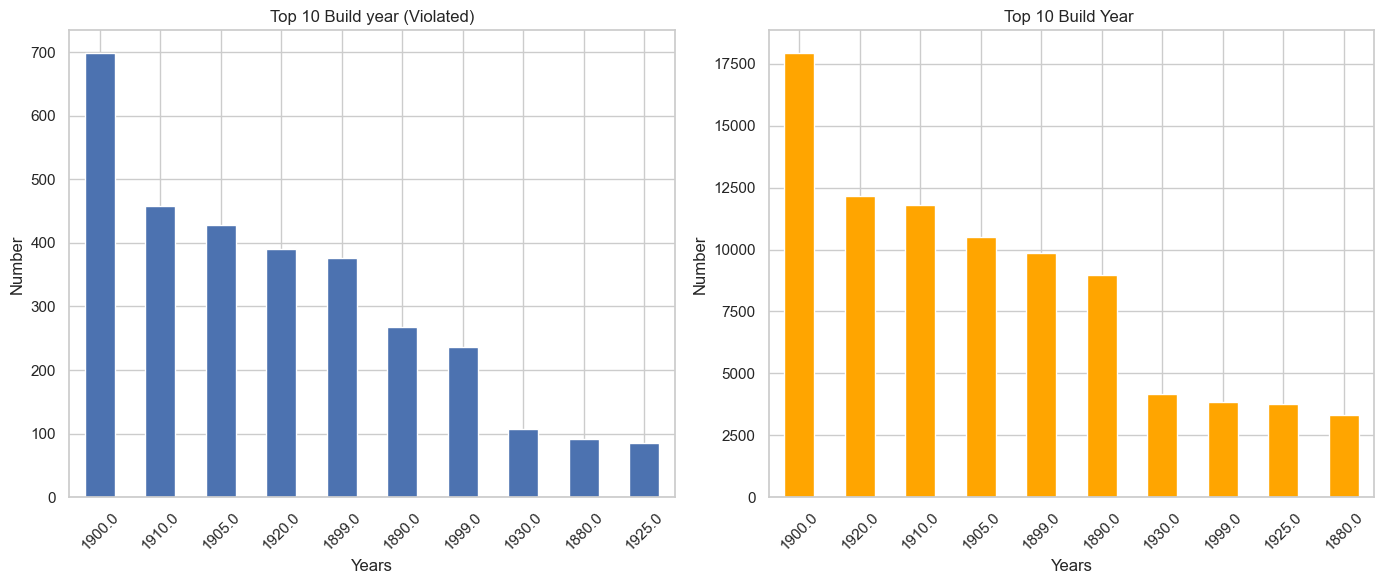

In [18]:
import matplotlib.pyplot as plt

top_build_type_prodf = prodf['YR_BUILT'].value_counts().head(10)
top_build_type_property_df = property_df['YR_BUILT'].value_counts().head(10)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
top_build_type_prodf.plot(kind='bar')
plt.title('Top 10 Build year (Violated)')
plt.xlabel('Years')
plt.ylabel('Number')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2) 
top_build_type_property_df.plot(kind='bar', color='orange')
plt.title('Top 10 Build Year ')
plt.xlabel('Years')
plt.ylabel('Number')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


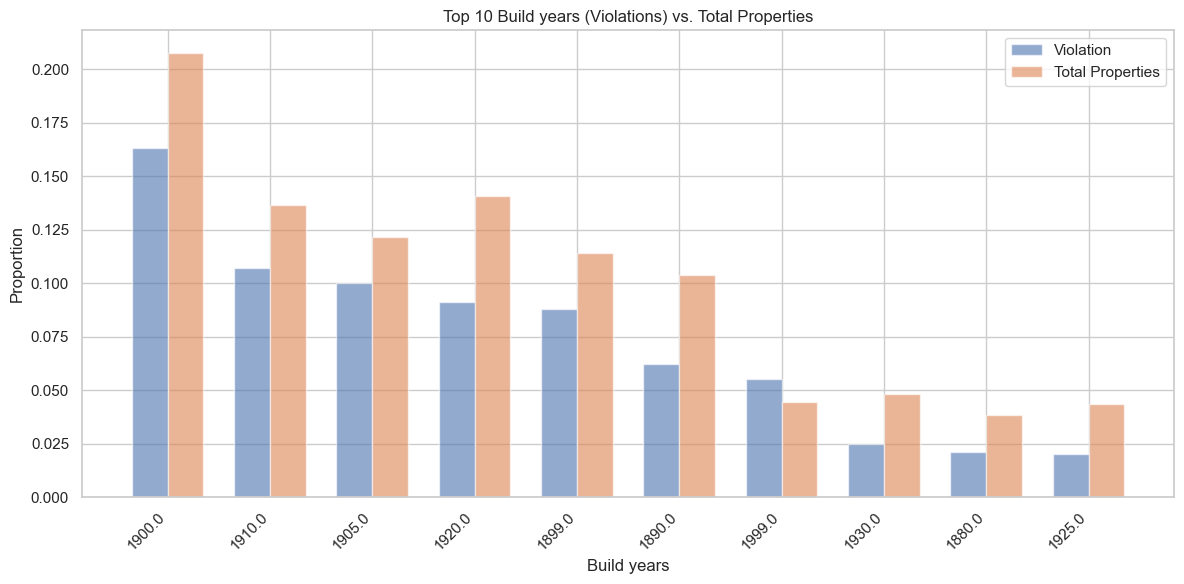

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

top_10_violation_types = prodf['YR_BUILT'].value_counts().head(10).index

top_10_violation_proportions = prodf['YR_BUILT'].value_counts(normalize=True).loc[top_10_violation_types]

top_10_property_proportions = property_df[property_df['YR_BUILT'].isin(top_10_violation_types)]['YR_BUILT'].value_counts(normalize=True)
top_10_property_proportions = top_10_property_proportions.reindex(top_10_violation_types)

plt.figure(figsize=(12, 6))

bar_width = 0.35
index = pd.Index(range(len(top_10_violation_types)))

plt.bar(index, top_10_violation_proportions, bar_width, label='Violation', alpha=0.6)

plt.bar(index + bar_width, top_10_property_proportions, bar_width, label='Total Properties', alpha=0.6)

plt.legend()

plt.title('Top 10 Build years (Violations) vs. Total Properties')
plt.xlabel('Build years')
plt.ylabel('Proportion')
plt.xticks(index + bar_width / 2, top_10_violation_types, rotation=45, ha='right')

plt.tight_layout()
plt.show()


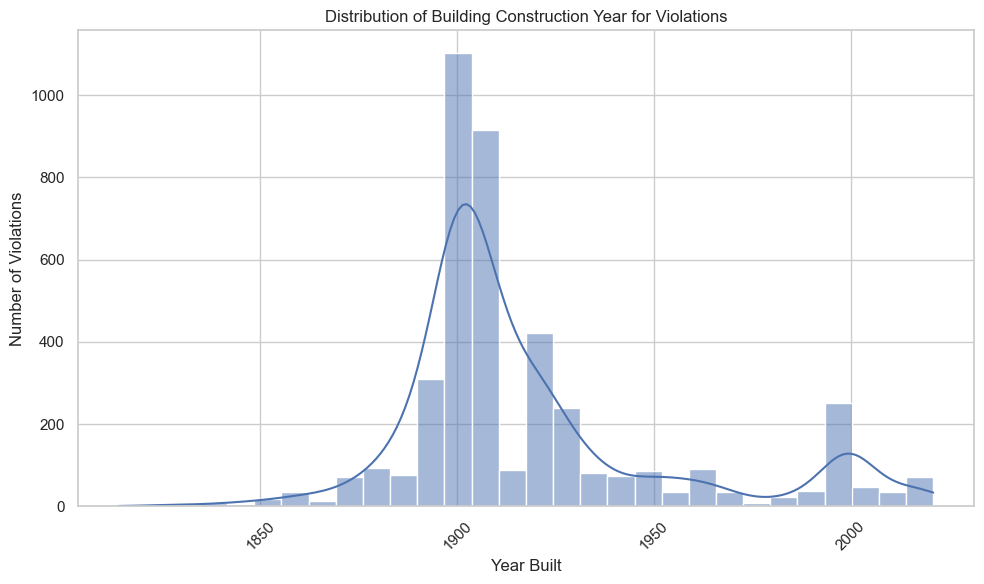

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

valid_years = prodf['YR_BUILT'].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(valid_years, bins=30, kde=True)
plt.title('Distribution of Building Construction Year for Violations')
plt.xlabel('Year Built')
plt.ylabel('Number of Violations')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


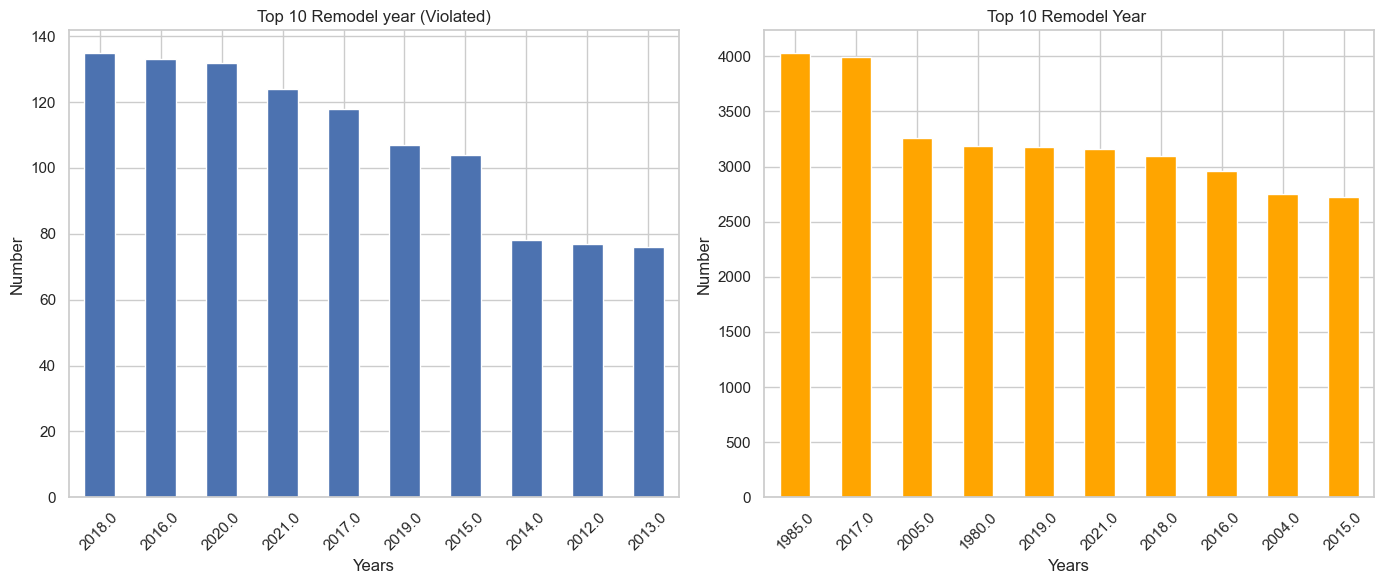

In [20]:
import matplotlib.pyplot as plt

top_build_type_prodf = prodf['YR_REMODEL'].value_counts().head(10)
top_build_type_property_df = property_df['YR_REMODEL'].value_counts().head(10)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
top_build_type_prodf.plot(kind='bar')
plt.title('Top 10 Remodel year (Violated)')
plt.xlabel('Years')
plt.ylabel('Number')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2) 
top_build_type_property_df.plot(kind='bar', color='orange')
plt.title('Top 10 Remodel Year ')
plt.xlabel('Years')
plt.ylabel('Number')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


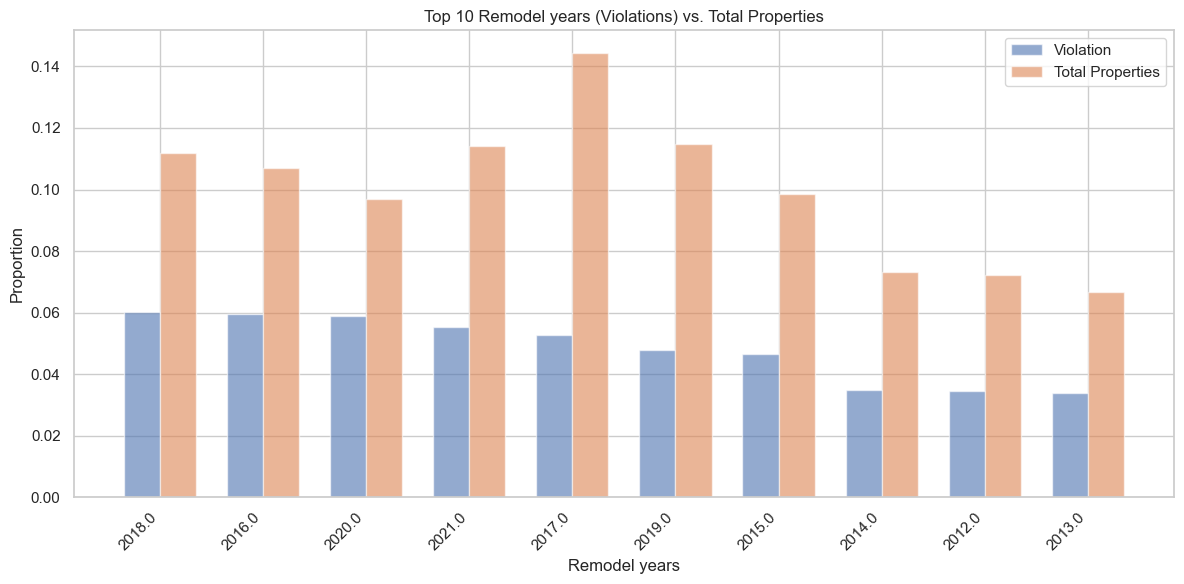

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

top_10_violation_types = prodf['YR_REMODEL'].value_counts().head(10).index

top_10_violation_proportions = prodf['YR_REMODEL'].value_counts(normalize=True).loc[top_10_violation_types]

top_10_property_proportions = property_df[property_df['YR_REMODEL'].isin(top_10_violation_types)]['YR_REMODEL'].value_counts(normalize=True)
top_10_property_proportions = top_10_property_proportions.reindex(top_10_violation_types)

plt.figure(figsize=(12, 6))

bar_width = 0.35
index = pd.Index(range(len(top_10_violation_types)))

plt.bar(index, top_10_violation_proportions, bar_width, label='Violation', alpha=0.6)

plt.bar(index + bar_width, top_10_property_proportions, bar_width, label='Total Properties', alpha=0.6)

plt.legend()

plt.title('Top 10 Remodel years (Violations) vs. Total Properties')
plt.xlabel('Remodel years')
plt.ylabel('Proportion')
plt.xticks(index + bar_width / 2, top_10_violation_types, rotation=45, ha='right')

plt.tight_layout()
plt.show()


## New Proportion(Merge with property assessment)

In [4]:
import pandas as pd
property_df = pd.read_csv('fy2023-property-assessment-data.csv')

In [5]:
property_df['Extracted_Address'] = property_df['OWNER MAIL ADDRESS'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else x)
# Remove the "#" character from the extracted addresses
property_df['Extracted_Address_Cleaned'] = property_df['Extracted_Address'].str.replace("#", "").str.upper()

# Showing the first few rows of the dataframe to confirm the removal
property_df[['OWNER MAIL ADDRESS', 'Extracted_Address', 'Extracted_Address_Cleaned']].head()


,OWNER MAIL ADDRESS,Extracted_Address,Extracted_Address_Cleaned
0,"195 LEXINGTON ST, EAST BOSTON, MA 02128",195 LEXINGTON ST,195 LEXINGTON ST
1,"197 LEXINGTON ST, EAST BOSTON, MA 02128",197 LEXINGTON ST,197 LEXINGTON ST
2,"199 LEXINGTON ST, EAST BOSTON, MA 02128",199 LEXINGTON ST,199 LEXINGTON ST
3,"PO BOX 557 #, EVERETT, MA 02149",PO BOX 557 #,PO BOX 557
4,"203 Lexington ST, EAST BOSTON, MA 02128",203 Lexington ST,203 LEXINGTON ST


In [6]:
# 确保 property_processed_build_vio 只包含 PID 在 processed_build_vio 的 PARCEL 中的行
property_processed_build_vio = property_df[property_df['PID'].isin(processed_build_vio['PARCEL'])]

# 使用 merge 方法将 latitude 和 longitude 列添加到 property_processed_build_vio
# 基于 property_processed_build_vio 的 'PID' 和 processed_build_vio 的 'PARCEL' 进行合并
property_processed_build_vio = property_processed_build_vio.merge(processed_build_vio[['PARCEL', 'latitude', 'longitude']],
                                                                  left_on='PID', right_on='PARCEL',
                                                                  how='left')

# 现在 property_processed_build_vio 包含了对应的经纬度信息，如果需要，可以删除 'PARCEL' 列
property_processed_build_vio = property_processed_build_vio.drop(columns=['PARCEL'])

# 查看合并后的 DataFrame 形状和前几行数据以验证结果
print(property_processed_build_vio.shape)


(6890, 64)


In [7]:
# 确保 property_processed_build_vio 只包含 PID 在 processed_build_vio 的 PARCEL 中的行
property_processed_code_vio = property_df[property_df['PID'].isin(processed_code_vio['PARCEL'])]

# 使用 merge 方法将 latitude 和 longitude 列添加到 property_processed_build_vio
# 基于 property_processed_build_vio 的 'PID' 和 processed_build_vio 的 'PARCEL' 进行合并
property_processed_code_vio = property_processed_code_vio.merge(processed_code_vio[['PARCEL', 'latitude', 'longitude']],
                                                                  left_on='PID', right_on='PARCEL',
                                                                  how='left')

property_processed_code_vio = property_processed_code_vio.drop(columns=['PARCEL'])

# 查看合并后的 DataFrame 形状和前几行数据以验证结果
print(property_processed_code_vio.shape)


(329155, 64)


## proportion(didn't merge to property assessment)

In [ ]:
total = pd.read_csv('./Live_Street_Address_Management_(SAM)_Addresses.csv')
total.shape

C:\Users\Wang\AppData\Local\Temp\ipykernel_4188\3117156479.py:1: DtypeWarning: Columns (8,9,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  total = pd.read_csv('./Live_Street_Address_Management_(SAM)_Addresses.csv')


(399908, 27)

In [10]:
from test2 import checkNeighborhood, poly
import pandas as pd


# processed_build_vio
neighborhoods = []

for index, row in processed_build_vio.iterrows():
    point = [row['latitude'], row['longitude']]
    neighborhood = checkNeighborhood(point, poly)
    neighborhoods.append(neighborhood)

# 将识别出的 neighborhood 列加入到 property_processed_build_vio DataFrame 中
processed_build_vio['Neighborhood'] = neighborhoods

# 计算每个 neighborhood 的违规数
violations_by_neighborhood = processed_build_vio['Neighborhood'].value_counts()




In [19]:
neighborhoods_total = []

for index, row in total.iterrows():
    point = [row['Y'], row['X']]
    neighborhood = checkNeighborhood(point, poly)
    neighborhoods_total.append(neighborhood)

total['Neighborhood'] = neighborhoods_total

total_neighborhood = total['Neighborhood'].value_counts()

Neighborhood
East Boston     0.069427
Dorchester      0.055212
Roxbury         0.051043
North End       0.050826
Mattapan        0.050225
Beacon Hill     0.047303
Hyde Park       0.047038
Chinatown       0.033854
Mission Hill    0.031871
South Boston    0.031788
Name: count, dtype: float64


<Axes: xlabel='Neighborhood'>

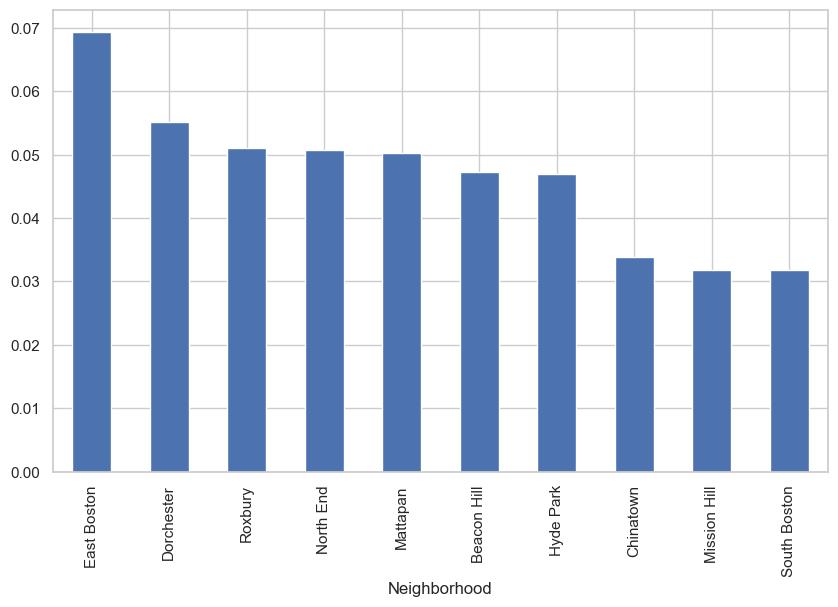

In [21]:
# 计算违规 neighborhood 在总 neighborhood 中的比例
violation_ratios = violations_by_neighborhood / total_neighborhood
violation_proportions = violation_ratios.sort_values(ascending=False)
violation_ratios_top10 = violation_proportions.head(10)


# 输出比例
print(violation_ratios_top10.dropna())  # 删除任何因为除法操作而产生的 NaN 值

violation_ratios_top10.plot(kind='bar', figsize=(10, 6))

In [22]:
from test2 import checkNeighborhood, poly
import pandas as pd


# 假设 property_processed_code_vio
neighborhoods = []

for index, row in processed_code_vio.iterrows():
    point = [row['latitude'], row['longitude']]
    neighborhood = checkNeighborhood(point, poly)
    neighborhoods.append(neighborhood)

# 将识别出的 neighborhood 列加入到 property_processed_build_vio DataFrame 中
processed_code_vio['Neighborhood'] = neighborhoods

# 计算每个 neighborhood 的违规数
violations_by_neighborhood2 = processed_code_vio['Neighborhood'].value_counts()




Neighborhood
Beacon Hill         4.201734
North End           2.914327
Mission Hill        2.852649
Back Bay            2.513880
Mattapan            2.241636
Dorchester          1.940350
East Boston         1.939538
Bay Village         1.887013
Roxbury             1.874968
Allston/Brighton    1.872170
Name: count, dtype: float64


<Axes: xlabel='Neighborhood'>

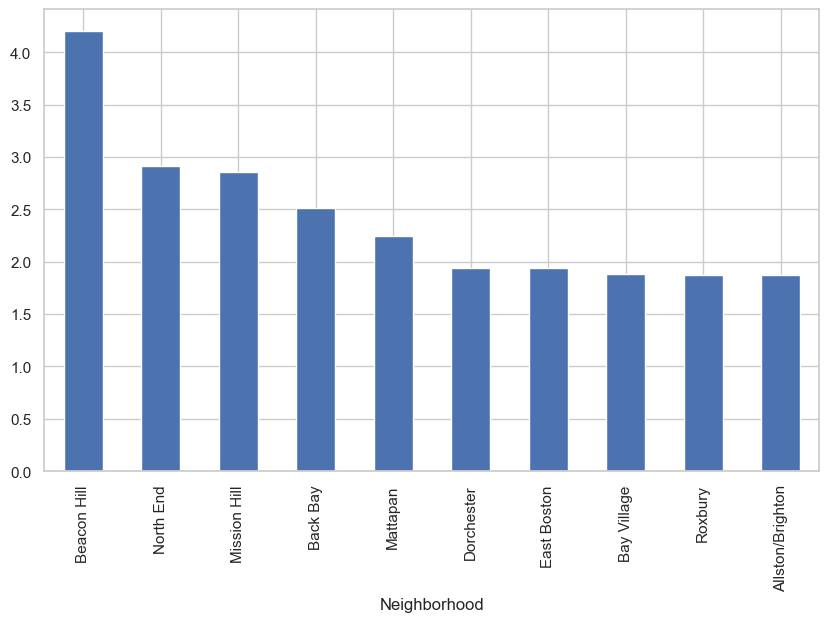

In [23]:
# 计算违规 neighborhood 在总 neighborhood 中的比例
violation_ratios2 = violations_by_neighborhood2 / total_neighborhood
violation_proportions2 = violation_ratios2.sort_values(ascending=False)
violation_ratios_top10_2 = violation_proportions2.head(10)


# 输出比例
print(violation_ratios_top10_2.dropna())  # 删除任何因为除法操作而产生的 NaN 值

violation_ratios_top10_2.plot(kind='bar', figsize=(10, 6))